代码还是有些问题，我遇到了MCMC采样不成功的问题，感觉一是数据量大，二是相比于之前的广义线性模型，这个7点评分的自变量复杂了很多，我没来得及试如果按照你之前吧rating分成三个部分的方法。
然后在过程中我为了简化模型把超先验也删去了，也调整了先验里的参数，但是还是不收敛
所以接下来要做的是
你可以继续试试现在这个能不能跑的通
把rating分成两个或者三个并进行哑变量处理，然后还是做广义的分层模型
做一个不用贝叶斯的，单纯是分层线性模型，rt还是满足exgaussian分布（这个我之前在R里面做了一部分了）

In [1]:
# import packages
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc3 as pm
#设置seed
np.random.seed(123)

In [2]:
data = pd.read_csv("./data/rt_tidy.csv")

In [3]:
data.head(10)

,Unnamed: 0,X.1,language,user_id,trait,stim_id,order,rt,rating,country,...,ethnicity.x,lab,block,X,Race,Gender,Age,ethnicity.y,gender,log_rt
0,1,606711,SPA,9654,confident,BM-040,41,1903,3,CO,...,NaN,COL_004,2,51,B,M,26.952381,black,male,7.551187
1,2,331376,HU,5381,responsible,WF-015,33,799,7,HU,...,"magyar, kaukázusi",HUN_001,2,93,W,F,24.211111,white,female,6.683361
2,3,162777,ENG,2734,attractive,LF-208,14,1226,1,US,...,Hispanic,USA_038,2,63,L,F,24.642857,latinx,female,7.111512
3,4,614094,SPA,9753,caring,BF-008,67,4561,7,CO,...,ninguno,COL_004,1,35,B,F,24.574713,black,female,8.425297
4,5,732055,PT,11726,aggressive,BF-201,36,912,3,PT,...,Caucasiana,POR_001,2,40,B,F,27.400000,black,female,6.815640
5,6,353796,ENG,5692,attractive,BF-047,105,1446,1,AU,...,Caucasian,AUS_007,1,39,B,F,34.213483,black,female,7.276556
6,7,437062,ENG,6884,mean,WM-256,73,1991,1,CA,...,South Asian,CAN_018,1,120,W,M,30.961538,white,male,7.596392
7,8,88967,ENG,1541,old,BF-004,3,1437,4,US,...,White,USA_113,2,32,B,F,26.983696,black,female,7.270313
8,9,438455,ENG,6897,caring,LM-243,63,2546,6,CA,...,white,CAN_018,2,86,L,M,21.642857,latinx,male,7.842279
9,10,701944,ENG,11134,aggressive,LM-219,13,1629,2,US,...,white,USA_054,1,81,L,M,26.703704,latinx,male,7.395722


# Preprocess

In [4]:
# create the new column that uses centralized rating
data['ratingcen'] = (data['rating'] - 5).abs() + 1

In [60]:
#pip install sns
#pip install --upgrade seaborn

SyntaxError: invalid syntax (4052137854.py, line 2)

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt


In [67]:
import sns
# Create a FacetGrid with boxplots
g = sns.FacetGrid(data, col='trait', col_wrap=2, sharex=False, sharey=False, height=4, aspect=1.5)
g.map(sns.boxplot, 'ratingcen', 'log_rt')

# Add labels and title
g.set_axis_labels('ratingcen', 'Reaction Time')
g.fig.suptitle('Boxplot of Reaction Time by rating, Across Different Stimulus Conditions')
plt.subplots_adjust(top=0.9)

# Show the plot
plt.show()

AttributeError: module 'sns' has no attribute 'FacetGrid'

/Users/nanwang/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


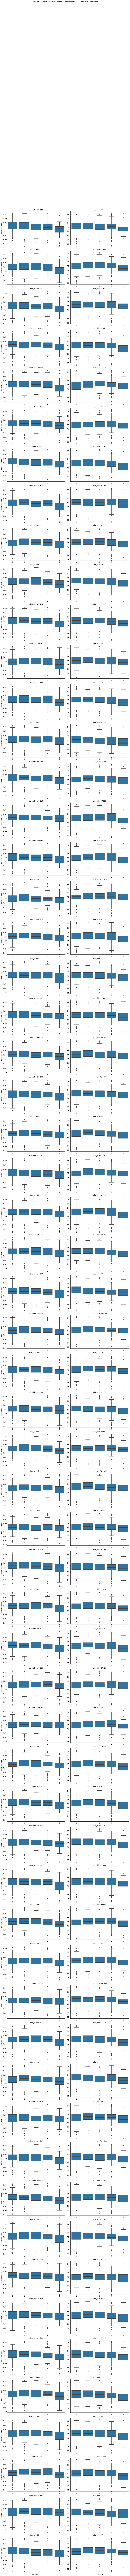

In [61]:
# Create a FacetGrid with boxplots
g = sns.FacetGrid(data, col='stim_id', col_wrap=2, sharex=False, sharey=False, height=4, aspect=1.5)
g.map(sns.boxplot, 'ratingcen', 'log_rt')

# Add labels and title
g.set_axis_labels('ratingcen', 'Reaction Time')
g.fig.suptitle('Boxplot of Reaction Time by rating, Across Different Stimulus Conditions')
plt.subplots_adjust(top=0.9)

# Show the plot
plt.show()

/Users/nanwang/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


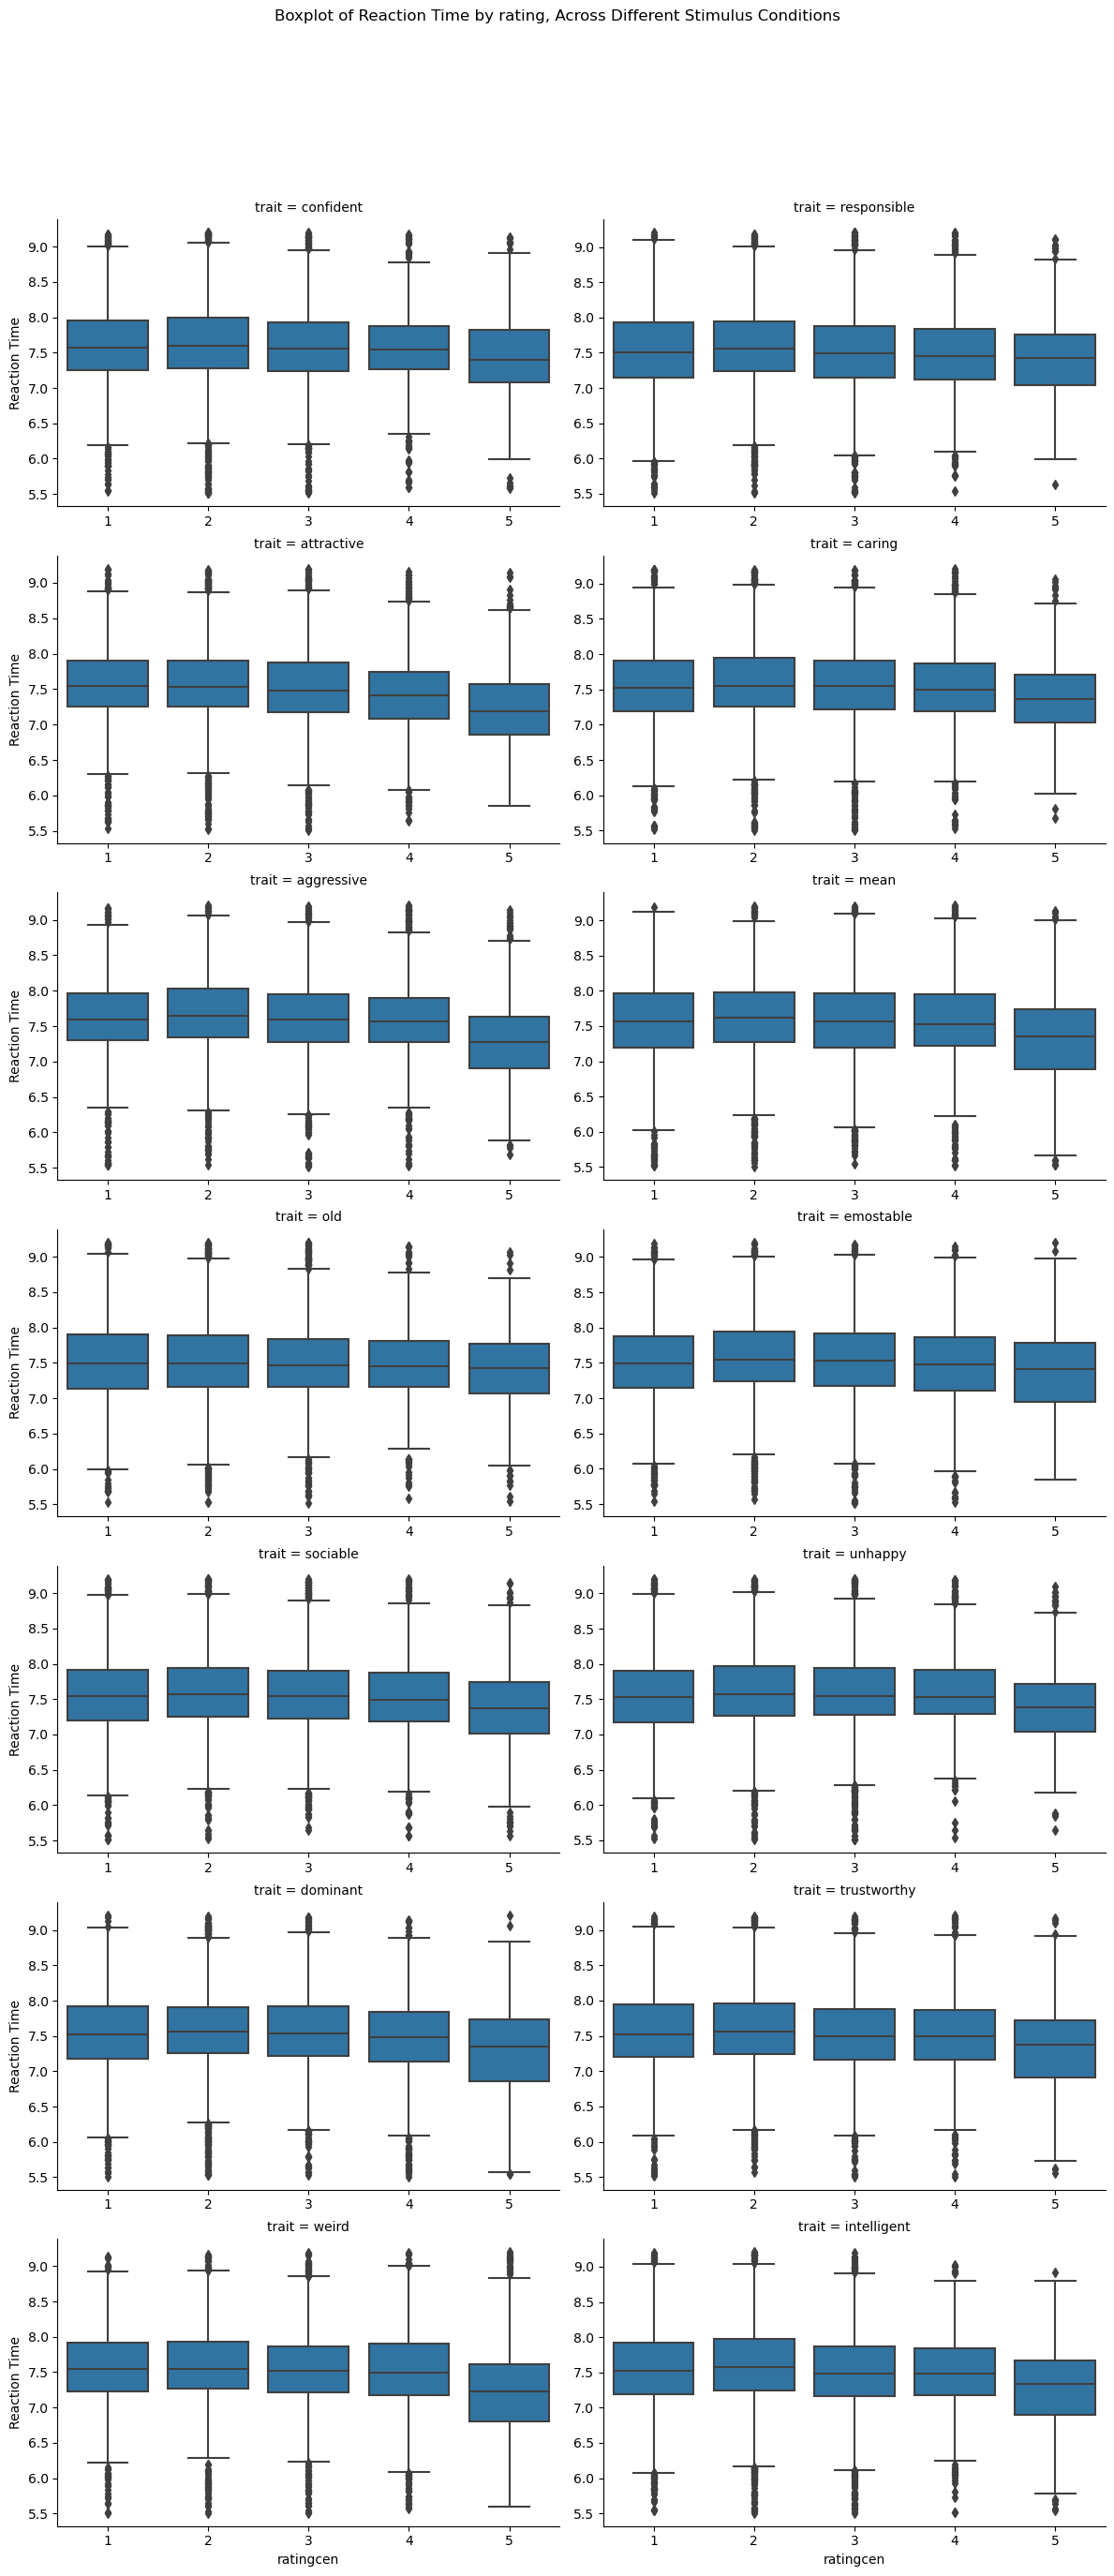

In [70]:
# Create a FacetGrid with boxplots
g = sns.FacetGrid(data, col='trait', col_wrap=2, sharex=False, sharey=False, height=4, aspect=1.5)
g.map(sns.boxplot, 'ratingcen', 'log_rt')

# Add labels and title
g.set_axis_labels('ratingcen', 'Reaction Time')
g.fig.suptitle('Boxplot of Reaction Time by rating, Across Different Stimulus Conditions')
plt.subplots_adjust(top=0.9)

# Show the plot
plt.show()

# Model 1

In [4]:
with pm.Model() as model_ExGaussian3:
    m_alpha = pm.Normal("m_alpha", mu=0, sigma=100)  
    m_beta = pm.Normal("m_beta", mu=0, sigma=50) 
    sig_alpha = pm.HalfNormal("sig_alpha", 100) 
    sig_beta = pm.HalfNormal("sig_beta", 100)
   
    # prior
    alpha = pm.Normal('alpha', mu=m_alpha,sd=sig_alpha)
    beta = pm.Normal('beta',mu=m_beta,sd=sig_beta)
    nu = pm.HalfNormal('nu', 100)
    sigma = pm.HalfNormal('sigma', 200)

In [5]:
with model_ExGaussian3:
    prior_checks = pm.sample_prior_predictive(samples=50)

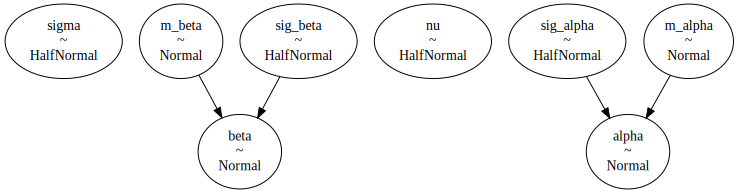

In [6]:
pm.model_to_graphviz(model_ExGaussian3)

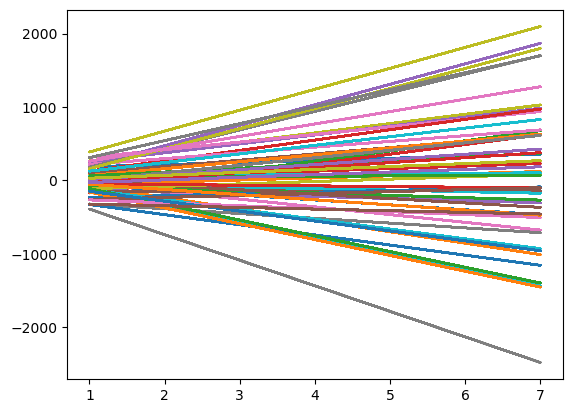

In [7]:
z = np.random.randint(1, 8,  100) #生成50个假数据，取值为[0,1]

for a, b in zip(prior_checks["alpha"], prior_checks["beta"]):
    y = a + b * z 
    plt.plot(z, y)

In [13]:
with pm.Model() as model_ExGaussian3:
    m_alpha = pm.Normal("m_alpha", mu=0, sigma=100)  
    m_beta = pm.Normal("m_beta", mu=0, sigma=50) 
    sig_alpha = pm.HalfNormal("sig_alpha", 50) 
    sig_beta = pm.HalfNormal("sig_beta", 50)
   
    # prior
    alpha = pm.Normal('alpha', mu=m_alpha,sd=sig_alpha)
    beta = pm.Normal('beta',mu=m_beta,sd=sig_beta)
    nu = pm.HalfNormal('nu', 50)
    sigma = pm.HalfNormal('sigma', 100)

    # x
    x = pm.Data("x", data.ratingcen)
    mu = pm.Deterministic("mu",  alpha+ beta*x) 

    y_obs = pm.ExGaussian("y_obs", mu=mu,sigma=sigma,nu=nu, observed=data.rt)

In [14]:
with model_ExGaussian3:
    trace = pm.sample(draws=1000,tune=800,target_accept=0.9,
                      chains=2, cores=2, init="adapt_diag")


WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
/Users/nanwang/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, nu, beta, alpha, sig_beta, sig_alpha, m_beta, m_alpha]


ValueError: Not enough samples to build a trace.

In [ ]:
az.plot_trace(trace,var_names=['alpha','beta','sigma'])

In [ ]:
with model_ExGaussian3:
    ppc_y = pm.sample_posterior_predictive(trace.posterior) 
az.concat(trace, az.from_pymc3(posterior_predictive=ppc_y), inplace=True)
az.plot_ppc(trace)

# Model 2

Model description: 

1. 根据preprocessing那边的可视化结果，当ratingcen=2， 5时，rt差别最大，因此本次建模只筛选rating=2，5
2. x=ratingcen, y=rt, 以country, stimulus, trait为分层变量，一个个往上加，本次只加一个 country（代表文化）的分层变量

In [18]:
# Filter rows based on rating
data2 = data[(data['ratingcen'] == 2) | (data['ratingcen'] == 5)]

data2['country'].unique()

array(['US', 'AU', 'CA', 'DE', 'AE', 'RU', 'NO', 'MY', 'NL', 'NZ', 'MX',
       'SK', 'CO', 'BR', 'BE', 'KE', 'RS', 'HK', 'GB', 'CN', 'ZA', 'CL',
       'IN', 'TR', 'SE', 'SV', 'EC', 'GR', 'HU', 'FR', 'TW', 'CH', 'DK',
       'AT', 'RO', 'ES', 'NG', 'PT', 'HT', 'TH', 'IR', 'CC', 'PE', 'AR',
       'PL', 'IT', 'TN', 'UG', 'EG', 'UA', 'GH', nan, 'FI', 'BY', 'LU',
       'CY', 'BG', 'ID', 'KH', 'MO', 'BD', 'KR', 'VN', 'CI', 'IE', 'AF',
       '--', 'AD', 'IL', 'KZ', 'LK', 'AX', 'UY', 'RW'], dtype=object)

In [19]:
country_idxs, country = pd.factorize(data2.country)

coords = {
    "country":
     country,
    "obs_id": np.arange(len(country_idxs)),
}

In [20]:
with pm.Model(coords=coords) as model_ExGaussian2:
    m_alpha = pm.Normal("m_alpha", mu=0, sigma=10)  
    sig_alpha = pm.HalfNormal("sig_alpha", 10)
    m_beta = pm.Normal("m_beta", mu=0, sigma=10)  
    sig_beta = pm.HalfNormal("sig_beta", 10)
   
    # prior 
    alpha = pm.Normal('alpha', mu=m_alpha,sd=sig_alpha, dims="country")
    beta = pm.Normal('beta',mu=m_beta,sd=sig_beta, dims="country")
    
    # x
    x = pm.Data("x", data2.ratingcen, dims="obs_id") # x is either two or five
    country_idx = pm.Data("country_idx", country_idxs, dims="obs_id")
    mu = pm.Deterministic("mu",  alpha[country_idxs]+ beta[country_idxs]*x) 
    nu = pm.HalfNormal('nu', 100)
    sigma = pm.HalfNormal('sigma', 100)
    
    
    y_obs = pm.ExGaussian("y_obs", mu=mu,sigma=sigma,nu=nu, observed=data2.rt, dims="obs_id")

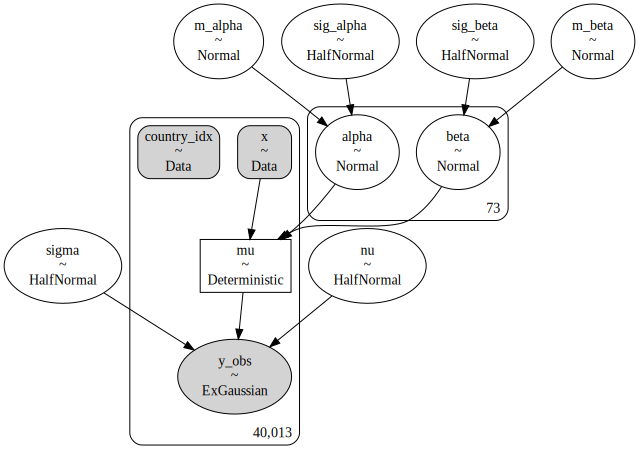

In [21]:
pm.model_to_graphviz(model_ExGaussian2)


In [23]:
# 检查先验
with model_ExGaussian2:
    prior_checks = pm.sample_prior_predictive(samples=1000)
     

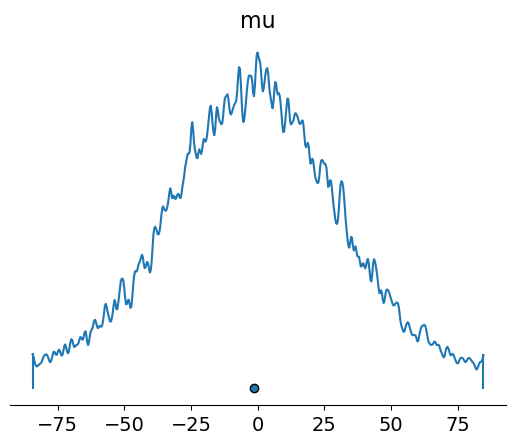

In [24]:
az.plot_density(
    {'mu':prior_checks['mu']}
    )
plt.show()
 


/Users/nanwang/opt/anaconda3/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (1000) than draws (73). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


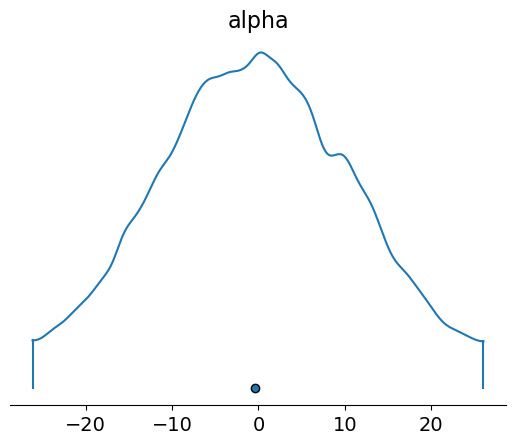

In [25]:
az.plot_density(
    {
        'alpha': prior_checks['alpha']
    }
    )
plt.show()

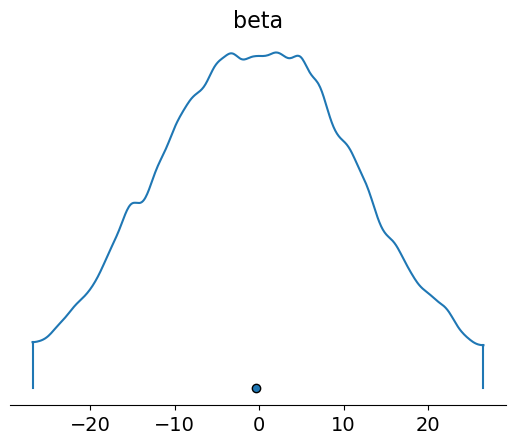

In [26]:
az.plot_density(
    {
        'beta': prior_checks['beta']
    }
    )
plt.show()

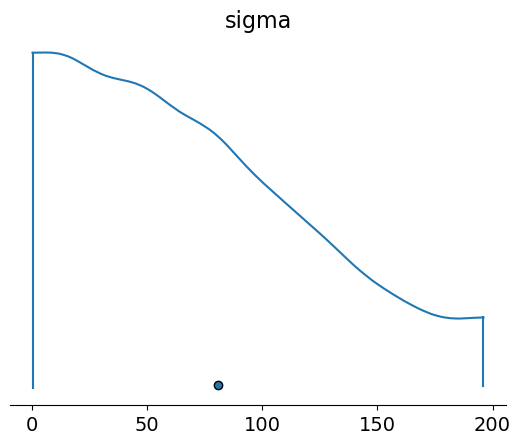

In [27]:
az.plot_density(
    {'sigma': prior_checks['sigma']
    }
    )
plt.show()

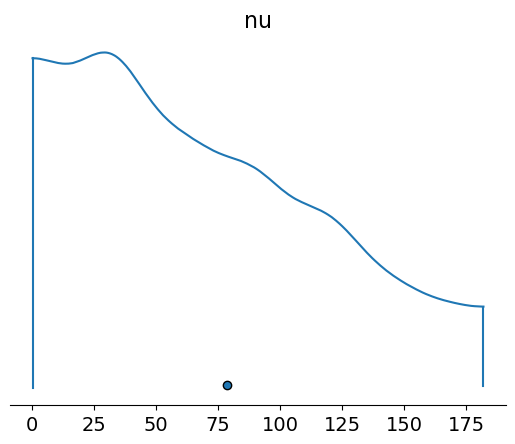

In [28]:
az.plot_density(
    {'nu': prior_checks['nu']
    }
    )
plt.show()

In [30]:
x = np.random.randint(2, size = 12) 

for a, b in zip(prior_checks["alpha"], prior_checks["beta"]):
    y1 = a + b * x 
    plt.plot(x, y1)

ValueError: operands could not be broadcast together with shapes (73,) (12,) 

In [31]:
#MCMC sampling
with model_ExGaussian2:
    trace_ExGaussian2 = pm.sample(draws = 1000, tune= 500, target_accept=0.8, chains=2, cores= 2,return_inferencedata=True,init="adapt_diag")

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, nu, beta, alpha, sig_beta, m_beta, sig_alpha, m_alpha]


/Users/nanwang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/nanwang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2679 seconds.
The acceptance probability does not match the target. It is 0.9663620636478089, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.983338078091512, but should be close to 0.8. Try to increase the number of tuning steps.


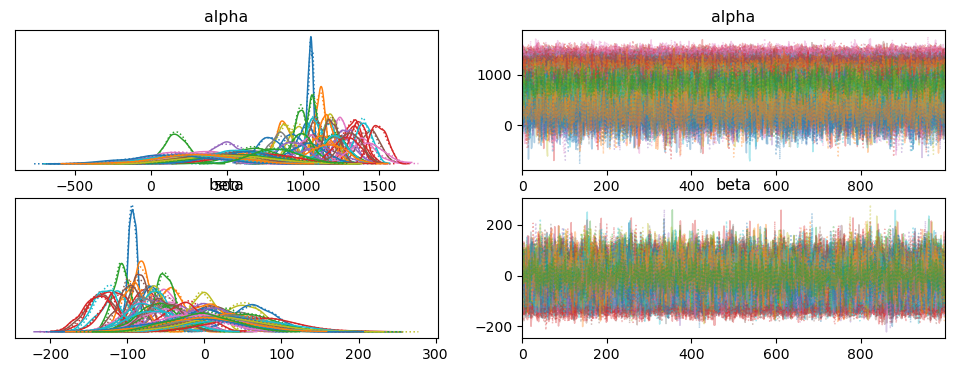

In [57]:
az.plot_trace(trace_ExGaussian2, var_names=['alpha','beta'])
plt.show()

In [33]:
# Generate summary table
summary_table = az.summary(trace_ExGaussian2, var_names=['alpha', 'beta'])

# Display the full table
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(summary_table)
    

#special countries: AE, HK, IN, TN, UG, EG, VN, IE, AF, AD, IL, KZ, LK, AX, UY


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[US],1049.285,19.751,1010.457,1085.132,0.426,0.301,2139.0,1494.0,1.00
alpha[AU],1113.016,31.506,1055.082,1172.300,0.796,0.563,1586.0,1410.0,1.00
alpha[CA],1061.254,35.043,996.466,1129.310,0.812,0.574,1869.0,1333.0,1.00
alpha[DE],1326.279,52.730,1227.760,1420.198,1.272,0.900,1729.0,1407.0,1.00
alpha[AE],499.856,114.035,288.736,708.457,2.966,2.098,1473.0,1241.0,1.00
alpha[RU],1432.090,71.003,1306.260,1568.933,1.653,1.170,1842.0,1244.0,1.00
alpha[NO],1239.299,51.584,1140.151,1333.407,1.131,0.800,2073.0,1141.0,1.00
alpha[MY],1181.051,53.539,1077.664,1278.194,1.249,0.883,1836.0,1295.0,1.00
alpha[NL],962.234,61.303,851.519,1080.744,1.252,0.888,2439.0,1321.0,1.00
alpha[NZ],1161.660,60.034,1051.631,1284.112,1.276,0.904,2211.0,1529.0,1.00


In [48]:
with model_ExGaussian2:
    #计算后验预测分布
    ppc_y = pm.sample_posterior_predictive(trace_ExGaussian3.posterior) 
#将ppc_y转化为InferenceData对象合并到trace中
az.concat(trace_ExGaussian3, az.from_pymc3(posterior_predictive=ppc_y), inplace=True)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/nanwang/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


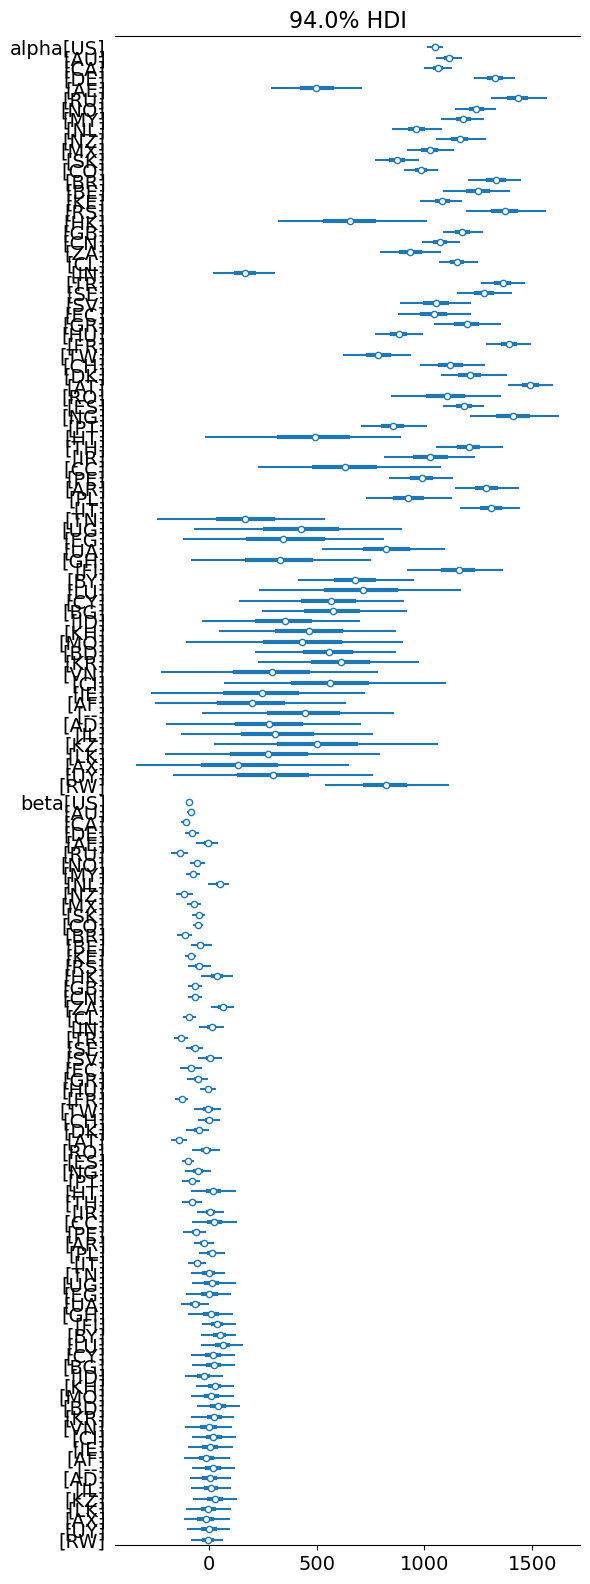

In [34]:
az.plot_forest(trace_ExGaussian2, var_names=['alpha', 'beta'], combined=True);

/Users/nanwang/opt/anaconda3/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (73) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'beta\nUS'}>,
        <AxesSubplot:title={'center':'beta\nAU'}>,
        <AxesSubplot:title={'center':'beta\nCA'}>,
        <AxesSubplot:title={'center':'beta\nDE'}>],
       [<AxesSubplot:title={'center':'beta\nAE'}>,
        <AxesSubplot:title={'center':'beta\nRU'}>,
        <AxesSubplot:title={'center':'beta\nNO'}>,
        <AxesSubplot:title={'center':'beta\nMY'}>],
       [<AxesSubplot:title={'center':'beta\nNL'}>,
        <AxesSubplot:title={'center':'beta\nNZ'}>,
        <AxesSubplot:title={'center':'beta\nMX'}>,
        <AxesSubplot:title={'center':'beta\nSK'}>],
       [<AxesSubplot:title={'center':'beta\nCO'}>,
        <AxesSubplot:title={'center':'beta\nBR'}>,
        <AxesSubplot:title={'center':'beta\nBE'}>,
        <AxesSubplot:title={'center':'beta\nKE'}>],
       [<AxesSubplot:title={'center':'beta\nRS'}>,
        <AxesSubplot:title={'center':'beta\nHK'}>,
        <AxesSubplot:title={'center':'beta\nGB'}>,
        <AxesSubplot:title=

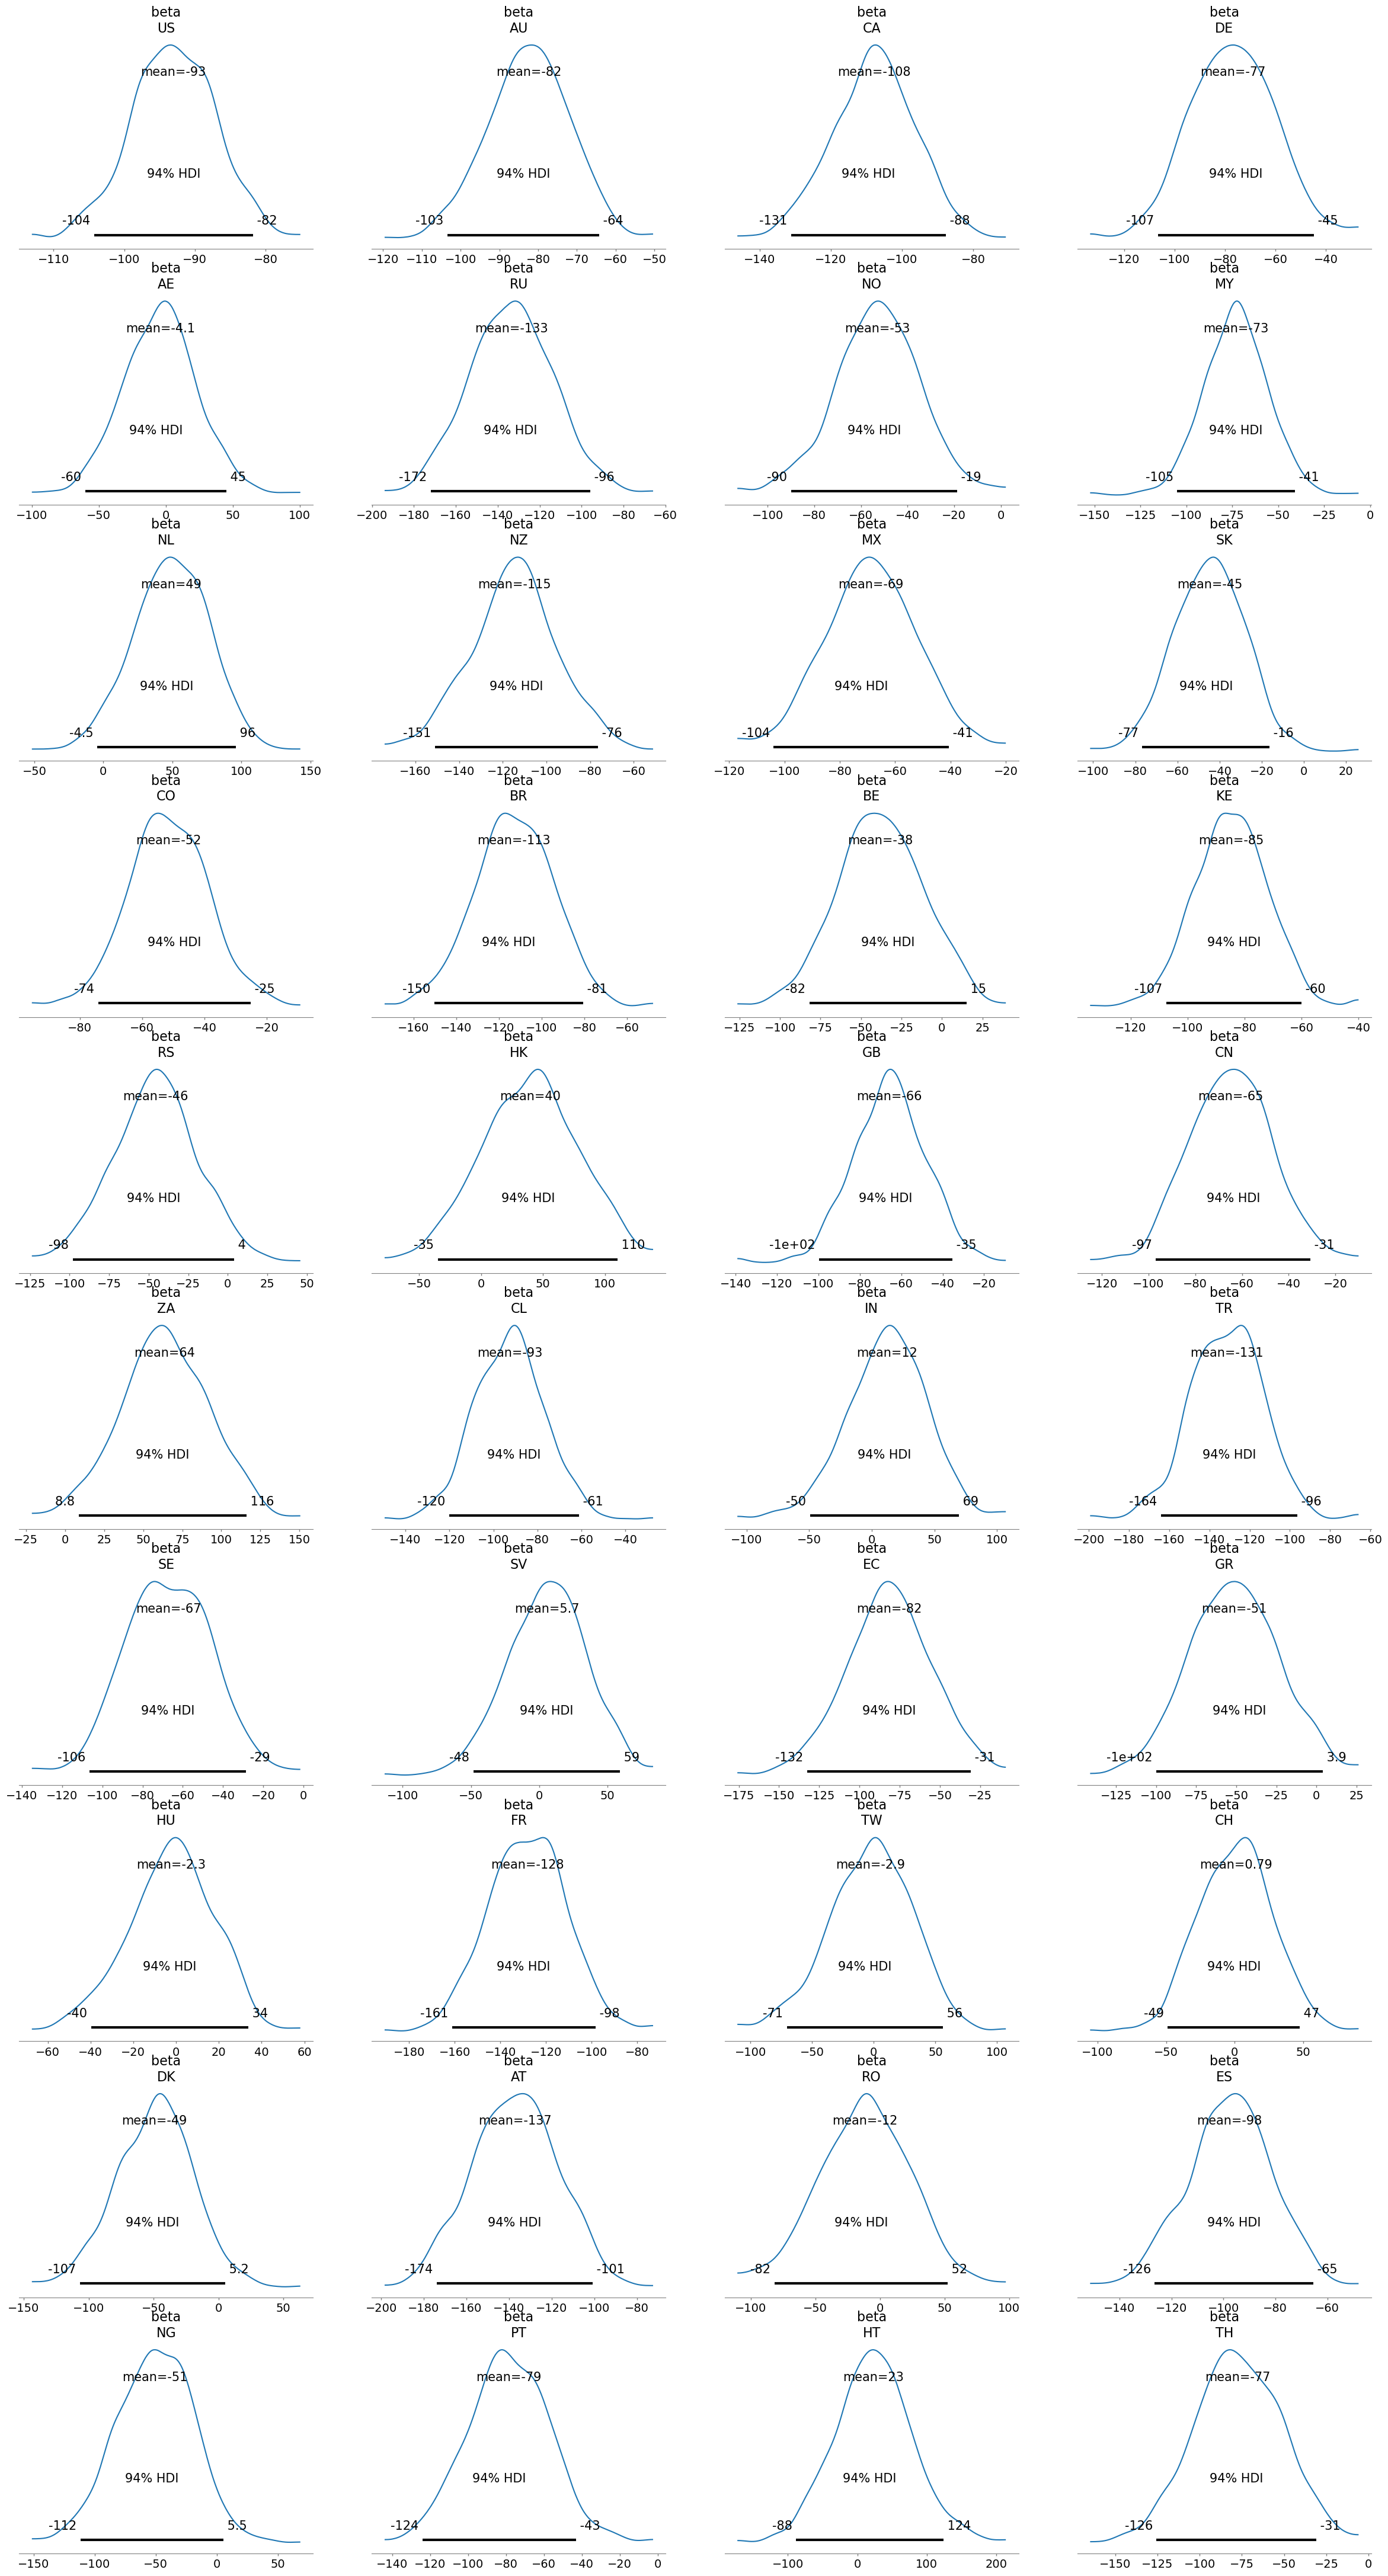

In [35]:
# look at the effect of rating across different countries
beta_country1 = trace_ExGaussian2.posterior["beta"][0]
az.plot_posterior(beta_country1)


array([<AxesSubplot:>], dtype=object)

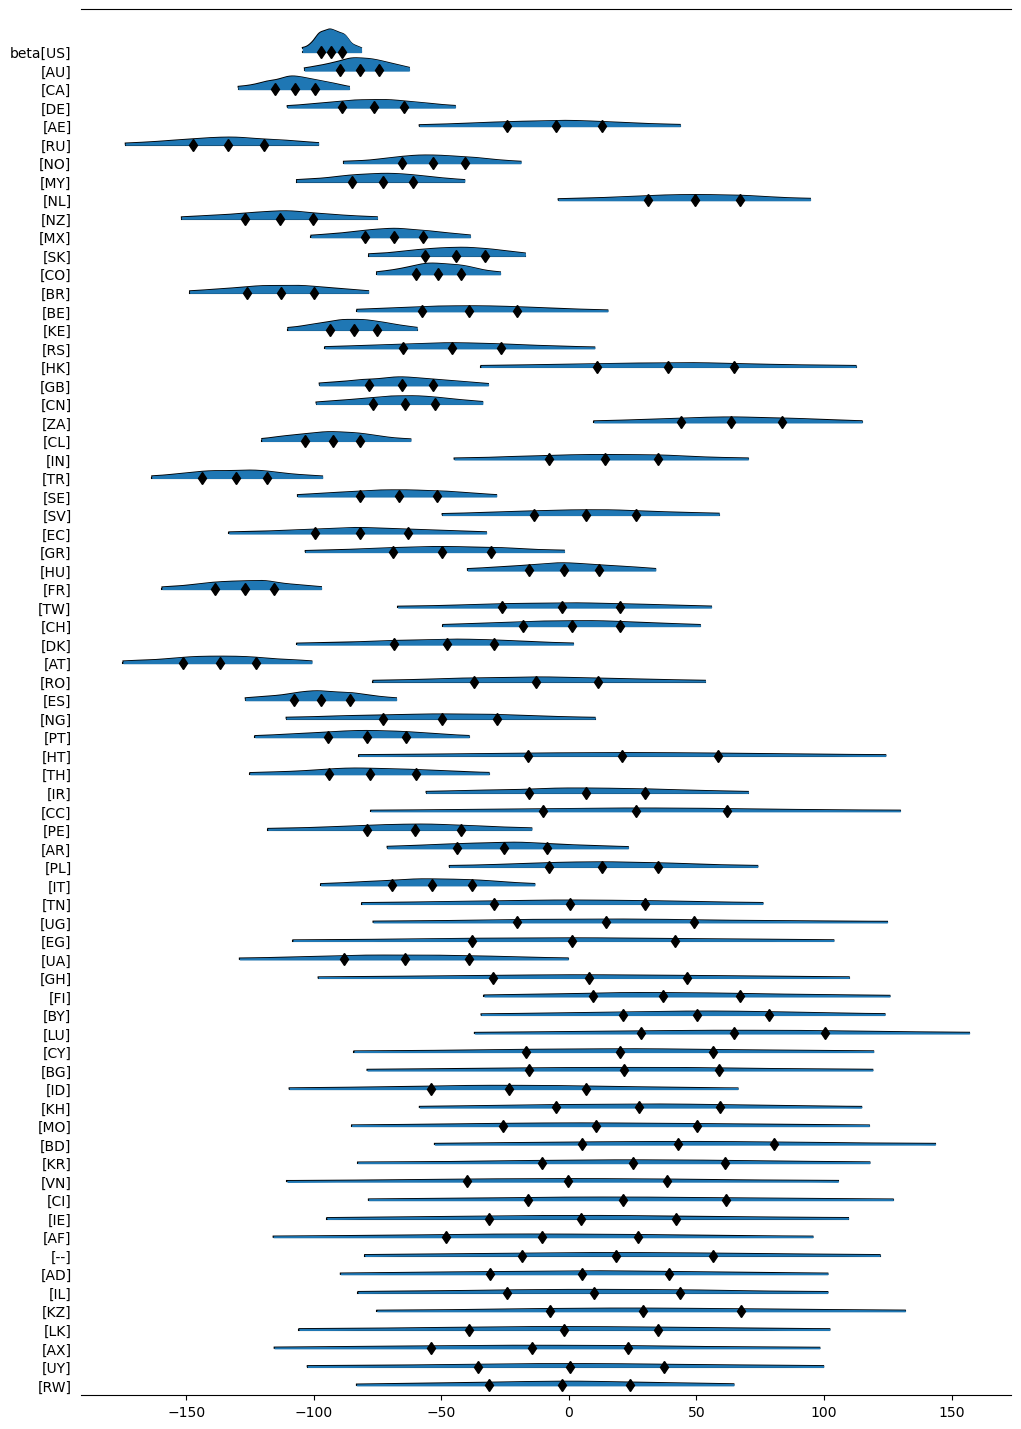

In [37]:
# visualize

# Extract beta posterior samples from the trace
beta_samples = trace_ExGaussian2.posterior["beta"].values

# Plot forest plot
az.plot_forest(
    trace_ExGaussian2,
    var_names=["beta"],
    coords={"country": country},
    combined=True,
    kind="ridgeplot",
    ridgeplot_quantiles=[0.25, 0.5, 0.75],
    ridgeplot_overlap=3,
    figsize=(12, 18),
)

In [41]:
# Extract beta means from summary table
beta_means = summary_table.loc[[var.startswith('beta') for var in summary_table.index], 'mean']


# Define cutoff values for high, medium, and low effect
high_cutoff = np.percentile(beta_means, 75)
low_cutoff = np.percentile(beta_means, 25)

# Classify countries into high, medium, and low effect groups
high_effect_countries = []
medium_effect_countries = []
low_effect_countries = []

for i, alpha_mean in enumerate(beta_means):
    if alpha_mean >= high_cutoff:
        high_effect_countries.append(summary_table.index[i])
    elif alpha_mean >= low_cutoff:
        medium_effect_countries.append(summary_table.index[i])
    else:
        low_effect_countries.append(summary_table.index[i])

# Print country names for each group
print('High effect countries:')
print(high_effect_countries)
print()

print('Medium effect countries:')
print(medium_effect_countries)
print()

print('Low effect countries:')
print(low_effect_countries)


High effect countries:
['alpha[NL]', 'alpha[HK]', 'alpha[ZA]', 'alpha[IN]', 'alpha[HT]', 'alpha[CC]', 'alpha[PL]', 'alpha[UG]', 'alpha[FI]', 'alpha[BY]', 'alpha[LU]', 'alpha[CY]', 'alpha[BG]', 'alpha[KH]', 'alpha[BD]', 'alpha[KR]', 'alpha[CI]', 'alpha[--]', 'alpha[KZ]']

Medium effect countries:
['alpha[AE]', 'alpha[NO]', 'alpha[SK]', 'alpha[CO]', 'alpha[BE]', 'alpha[RS]', 'alpha[GB]', 'alpha[CN]', 'alpha[SE]', 'alpha[SV]', 'alpha[GR]', 'alpha[HU]', 'alpha[TW]', 'alpha[CH]', 'alpha[DK]', 'alpha[RO]', 'alpha[NG]', 'alpha[IR]', 'alpha[PE]', 'alpha[AR]', 'alpha[IT]', 'alpha[TN]', 'alpha[EG]', 'alpha[UA]', 'alpha[GH]', 'alpha[ID]', 'alpha[MO]', 'alpha[VN]', 'alpha[IE]', 'alpha[AF]', 'alpha[AD]', 'alpha[IL]', 'alpha[LK]', 'alpha[AX]', 'alpha[UY]', 'alpha[RW]']

Low effect countries:
['alpha[US]', 'alpha[AU]', 'alpha[CA]', 'alpha[DE]', 'alpha[RU]', 'alpha[MY]', 'alpha[NZ]', 'alpha[MX]', 'alpha[BR]', 'alpha[KE]', 'alpha[CL]', 'alpha[TR]', 'alpha[EC]', 'alpha[FR]', 'alpha[AT]', 'alpha[ES]', 'a

explanation of the codes:

High effect countries:
The Netherlands, Hong Kong, South Africa, India, Haiti, Cocos (Keeling) Islands, Poland, Uganda, Finland, Belarus, Luxembourg, Cyprus, Bulgaria, Cambodia, Bangladesh, South Korea, Cote d'Ivoire (Ivory Coast), International Freephone Service, Kazakhstan.

Medium effect countries:
United Arab Emirates, Norway, Slovakia, Colombia, Belgium, Serbia, United Kingdom, China, Sweden, El Salvador, Greece, Hungary, Taiwan, Switzerland, Denmark, Romania, Nigeria, Iran, Peru, Argentina, Italy, Tunisia, Egypt, Ukraine, Ghana, Indonesia, Macau, Vietnam, Ireland, Afghanistan, Andorra, Israel, Sri Lanka, Åland Islands, Uruguay, Rwanda.

Low effect countries:
United States, Australia, Canada, Germany, Russia, Malaysia, New Zealand, Mexico, Brazil, Kenya, Chile, Turkey, Ecuador, France, Austria, Spain, Portugal, Thailand.

## to do list 

re-organize the countries into different regions and check the influence again
re-organize face into races

总体上的效果

# Model 3

这时候再加layer

In [53]:
# Creating the factorized index for country and stimulus ID
country_idxs, country = pd.factorize(data2.country)
stim_id_idxs, stim_id = pd.factorize(data2.stim_id)


# Create dictionary of coordinates
coords = {
    'country': country,
    'stim_id': stim_id,
    'obs_id': np.arange(len(data2)), # len 的长度多少？
}


In [54]:
# model 3.1  [my choice]

with pm.Model(coords=coords) as model_ExGaussian3:
    # Priors for hyperparameters
    m_alpha = pm.Normal("m_alpha", mu=0, sigma=10)  
    sig_alpha = pm.HalfNormal("sig_alpha", 10)
    m_beta = pm.Normal("m_beta", mu=0, sigma=10)  
    sig_beta = pm.HalfNormal("sig_beta", 10)
    
    # Priors for stimulus-specific parameters
    alpha_stim = pm.Normal('alpha_stim', mu=0, sd=10, dims=('stim_id', 'country'))
    beta_stim = pm.Normal('beta_stim', mu=0, sd=10, dims=('stim_id', 'country'))

    # Priors for country-specific parameters
    alpha_country = pm.Normal('alpha_country', mu=m_alpha, sd=sig_alpha, dims='country')
    beta_country = pm.Normal('beta_country', mu=m_beta, sd=sig_beta, dims='country')

    # Priors for stimulus-specific intercept and slope
    alpha = alpha_country[country_idxs] + alpha_stim[stim_id_idxs, country_idxs]
    beta = beta_country[country_idxs] + beta_stim[stim_id_idxs, country_idxs]

    # Data likelihood
    x = pm.Data("x", data2.ratingcen, dims="obs_id")
    mu = pm.Deterministic("mu", alpha + beta*x)
    nu = pm.HalfNormal('nu', 100)
    sigma = pm.HalfNormal('sigma', 100)
    y_obs = pm.ExGaussian("y_obs", mu=mu, sigma=sigma, nu=nu, observed=data2.rt, dims="obs_id")


In [ ]:
# model 3.2 

with pm.Model(coords=coords) as model_ExGaussian3:
    # Hyperpriors
    m_alpha = pm.Normal("m_alpha", mu=0, sigma=10)
    sig_alpha = pm.HalfNormal("sig_alpha", 10)
    m_beta = pm.Normal("m_beta", mu=0, sigma=10)
    sig_beta = pm.HalfNormal("sig_beta", 10)
    m_gamma = pm.Normal("m_gamma", mu=0, sigma=10)
    sig_gamma = pm.HalfNormal("sig_gamma", 10)

    # Priors
    alpha = pm.Normal('alpha', mu=m_alpha, sd=sig_alpha, dims=("country"))
    beta = pm.Normal('beta', mu=m_beta, sd=sig_beta, dims=("country"))
    gamma = pm.Normal('gamma', mu=m_gamma, sd=sig_gamma, dims=("stim_id"))

    # Variables
    x = pm.Data("x", data2.ratingcen, dims="obs_id")
    country_idx = pm.Data("country_idx", country_idxs, dims="obs_id")
    stim_id_idx = pm.Data("stim_id_idx", stim_id_idxs, dims="obs_id")
    mu = pm.Deterministic("mu", alpha[country_idxs] + beta[country_idxs] * x + gamma[stim_id_idxs])
    nu = pm.HalfNormal('nu', 100)
    sigma = pm.HalfNormal('sigma', 100)
    
    
    # Likelihood
    y_obs = pm.ExGaussian("y_obs", mu=mu, sigma=sigma, nu=nu, observed=data2.rt, dims="obs_id")

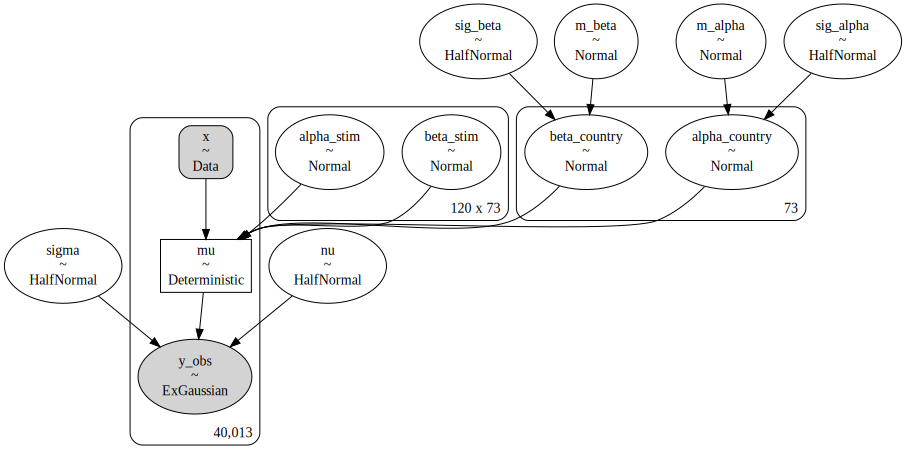

In [56]:
pm.model_to_graphviz(model_ExGaussian3)

In [ ]:
#MCMC sampling
with model_ExGaussian3:
    trace_ExGaussian3 = pm.sample(draws = 1000, tune= 500, target_accept=0.8, chains=2, cores= 2,return_inferencedata=True,init="adapt_diag")